# Прогнозирование оттока клиентов оператора связи

Оператор связи запускает инициативу по снижению оттока клиентов. Чтобы удерживать пользователей, планирующих разорвать договор, компания предлагает им специальные условия и промокоды. Для реализации этой стратегии оператору необходим инструмент, который позволит заранее выявлять таких клиентов.

**Цель исследования:** Построить модель машинного обучения для предсказания вероятности расторжения договора клиентом.

Таким образом, исследование пройдёт в **семь этапов**:
1) Обзор данных
2) Предобработка данных
3) Исследовательный анализ данных
4) Корреляционный анализ данных
5) Подготовка данных к обучению
6) Обучение моделей
7) Анализ результатов

 **Условия проекта**:
- Значение метрики ROC-AUC не менее 0.85 на тестовой выборке. 

## Загрузка и импорт библиотек <a class="anchor" id="импорт"></a>

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score
)

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

In [2]:
def load_file(file_name, *args, **kwargs):
    '''
    Проверка пути файла и загрузка файла
    '''
    if os.path.exists(file_name):
        return pd.read_csv(file_name, *args, **kwargs)
    elif os.path.exists(f'/datasets/{file_name}'):
        return pd.read_csv(f'/datasets/{file_name}', *args, **kwargs)
    else:
        raise FileNotFoundError(f"Файл {file_name} не найден.")

In [3]:
def data_info(df):
    '''
    Отображает первые 5 строк, общую информацию и описательную статистику DataFrame,
    количество пропущенных значений и явных дубликатов.
    '''
    display(df.head())
    df.info()
    display(df.describe().round(3))
    print('Количество пропусков:',
          df.isna().sum(), sep='\n', end='\n\n')
    print('Количество дубликатов:', 
          df.duplicated().sum())

In [4]:
def to_snake_case(name):
    '''
    Преобразование заголовка в snake_case и приведение к нижнему регистру
    '''
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name).lower()
    return name

In [5]:
def category_col_unique(df):
    '''
    Вывод уникальных значений в столбце типа 'object'
    '''
    for column in df.columns:
        if column != 'customer_id':
            if df[column].dtypes == 'object':
                print(f'Уникальные значения в столбце {column}:', df[column].unique())

In [6]:
def plt_pie_pivot (df, column, title, figsize=(5, 5)):
    '''
    Создает сводную таблицу и круговую диаграмму для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, по которому будет строиться сводная таблица и диаграмма.
        title (str): Заголовок для диаграммы.
    '''
    
    # Сводная таблица
    column_pivot = (
        df
        .pivot_table(index=column,values='customer_id', aggfunc='count')
        .sort_values(by='customer_id', ascending=False)
        )
    column_pivot.columns = ['Количество']
    display(column_pivot)

    # Круговая диаграмма
    column_pivot.plot(kind='pie', figsize=figsize, subplots=True, autopct='%1.2f%%', ylabel='', 
                      colormap='tab10', fontsize=12, legend=False)
    plt.title(title, fontsize=14)
    plt.show()

In [7]:
def plt_hist_boxplt(df, column, title, label, bins=30, 
                     hue=None, xlim=None, color=None):
    '''
    Строит гистограмму и диаграмму размаха для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, для которого будут строиться графики.
        title (str): Заголовок для графиков.
        label (str): Название оси x для обоих графиков.
        hue (str): Кательгориальный столбец для разбивки. По умолчанию None
        bins (int, optional): Количество бинов для гистограммы. По умолчанию 30.
        xlim (tuple, optional): Пределы для оси x. По умолчанию None.
        color (str, optional): Цвет графиков. По умолчанию None.
    '''
    
    # Описательные статистики
    print(f'Описательные статистики параметра {title}')
    display(pd.DataFrame(df[column].describe()))
    
    # Построение графиков
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    
    # Гистограмма
    sns.histplot(data=df, x=column, hue=hue, bins=bins, ax=ax1, color=color)
    ax1.set_title(f'1 - {title}', fontsize=14)
    ax1.set_xlabel(label)
    ax1.set_ylabel('Частота')
    ax1.set_xlim(xlim)

    # Диаграмма размаха
    sns.boxplot(data=df, x=hue, y=column, ax=ax2, palette='tab10', width=.5)
    ax2.set_title(f'2 - {title}', fontsize=14)
    ax2.set_ylabel(label)
    ax2.set_xlabel('Ушел ли клиент')
    ax2.set_xlim(xlim)

    plt.tight_layout()
    plt.show()

In [8]:
def plt_bar_hue(df, column, xlabel, title, values='customer_id', aggfunc='count', ylabel='Количество', 
             hue=None, figsize=(6, 5), display_pivot=False, display_bar_label=False):
    '''
    Создает вертикальную столбчатую диаграмму в разрезе категории для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, по которому будет строиться сводная таблица и диаграмма.
        xlabel (str): Название оси x для диаграммы.
        title (str): Заголовок диаграммы.
        hue (str): Столбец для разбивки. По умолчанию None
        values (str, optional): Столбец для агрегации в сводной таблице. По умолчанию 'id'.
        aggfunc (str or function, optional): Функция агрегации для сводной таблицы. По умолчанию 'count'.
        ylabel (str, optional): Название оси y для диаграммы. По умолчанию 'Количество'.
        figsize (tuple, optional): Размеры фигуры (ширина, высота). По умолчанию (6, 5).
        display_pivot (bool, optional): Отображать сводную таблицу перед построением диаграммы. По умолчанию False.
    '''
    
    # Сводная таблица
    column_pivot_bar = (
        df
        .pivot_table(index=[column, hue], values=values, aggfunc=aggfunc)
        .reset_index()
        .sort_values(by=values, ascending=False)
    )
    
    if display_pivot:
        display(column_pivot_bar)

    # Столбчатая диаграмма
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=column_pivot_bar, x=column, y=values, hue=hue, palette='tab10')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title, fontsize=14)

     # Добавление меток с абсолютными значениями на столбики
    if display_bar_label:
        for container in ax.containers:
            ax.bar_label(container, fontsize=11)
            
    plt.show()

## Загрузка и обзор данных <a class="anchor" id="загрузка"></a>

In [9]:
# Загрузка данных
try:
    contract = load_file('contract_new.csv', parse_dates=['BeginDate', 'EndDate'])
    internet = load_file('internet_new.csv')
    personal = load_file('personal_new.csv')
    phone = load_file('phone_new.csv')
    print('Данные успешно загружены')
except:
    print('Ошибка при загрузке')

Данные успешно загружены


In [10]:
# Вывод общей информации о датафрейме 'contract'
data_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


,BeginDate,MonthlyCharges
count,7043,7043.000
mean,2017-04-30 13:01:50.918642688,64.762
min,2013-10-01 00:00:00,18.250
25%,2015-06-01 00:00:00,35.500
50%,2017-09-01 00:00:00,70.350
75%,2019-04-01 00:00:00,89.850
max,2020-02-01 00:00:00,118.750
std,NaN,30.090


Количество пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество дубликатов: 0


In [11]:
# Вывод общей информации о датафрейме 'internet'
data_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество дубликатов: 0


In [12]:
# Вывод общей информации о датафрейме 'personal'
data_info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000
mean,0.162
std,0.369
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


Количество пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество дубликатов: 0


In [13]:
# Вывод общей информации о датафрейме 'phone'
data_info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество пропусков:
customerID       0
MultipleLines    0
dtype: int64

Количество дубликатов: 0


**Общая предварительная оценка данных:**
- Данные представляют собой информацию о клиентах, их тарифах и услугах. Статистика по заключенным договорам с 2013-10-01 по 2020-02-01 включительно.
- Данные разделены на 4 датафрейма: `contract` содержит 7043 строк с информацией о договорах клиентов; `personal` содержит 7043 строк с персональными данными клиентов; `internet` содержит 5517 строк с информацией об интернет-услугах, подключенных у клиента; `phone` содержит 6361 строк с данными об услугах телефонии.
- Часть признаков имеет неверно определенный тип данных.
- В данных отсутствуют пропущенные значения, а также явные дубликаты. Однако необходимо проверить данные на наличие неявных дубликатов и пропусков.
- Данные не размечены, т.е. не указан целевой признак. Необходимо, исходя из предоставленных параметров, выделить целевой признак и разметить данные.

Для дальнейшей работы с данными выполним их предобработку.

## Предобработка данных <a class="anchor" id="предобработка"></a>

### Переименование столбцов <a class="anchor" id="столбцы"></a>

Для удобства работы с признаками, изменим все названия столбцов в соответствии со стандартами оформления: приведем к нижнему регистру и к стилю snake_case.

In [14]:
# Словарь со всеми датафреймами
all_df = {
    'contract': contract,
    'personal': personal,
    'internet': internet,
    'phone': phone
}

# Названия столбцов каждого датафрейма
for name, df in all_df.items():
    print(f'Названия столбцов {name}:', df.columns)

Названия столбцов contract: Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Названия столбцов personal: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
Названия столбцов internet: Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')
Названия столбцов phone: Index(['customerID', 'MultipleLines'], dtype='object')


In [15]:
# Приведение названий столбцов к snake_case
for name, df in all_df.items():
    df.columns = [to_snake_case(col) for col in df.columns]

# Просмотр результатов
for name, df in all_df.items():
    print(f'Названия столбцов {name}:', df.columns)

Названия столбцов contract: Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Названия столбцов personal: Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Названия столбцов internet: Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Названия столбцов phone: Index(['customer_id', 'multiple_lines'], dtype='object')


### Изменение типов данных <a class="anchor" id="типы_данных"></a>

Для дальнейшей работы с датафреймом `contract` приведем данные к корректным типам (в остальных датафреймах все типы верные).

In [16]:
# Проверка типов данных 
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
dtype: object

Изменим типы в следующих столбцах:
* `end_date`  - переведем в *'datetime64'*, т.к. столбец содержит дату окончания действия договора.
* `total_charges` - заменим *'float64'*, чтобы была возможность проводить с данными математические операции.

Перед этим проверим какие значения встречаются в указанных столбцах, чтобы понять, почему при загрузке файла тип данных был определен неверно.

In [17]:
# Уникальные значения в столбце 'end_date'
contract['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

В столбце помимо дат встречается значение **'No'**, т.е. показатель того, что клиент не разорвал договор и он активный. Приведем значения к корректному формату: даты останутся датами. 'No' заменим на NaT (Not a Time), чтобы указать, что договор активен.

На основе столбца `end_date` создадим **целевой признак `churn` (отток)**: 1 - если договор разорван и 0 - договор активен.

In [18]:
# Замена типа данных в 'end_date'
contract['end_date'] = pd.to_datetime(contract['end_date'].replace('No', pd.NaT), errors='coerce')
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
dtype: object

In [19]:
# Создание целевого признка 'churn'
contract['churn'] = contract['end_date'].notna().astype(int)
contract['churn'].value_counts()

churn
0    5942
1    1101
Name: count, dtype: int64

Далее проверим, какие нечисловые значения встречаются в столбце `total_charges`:

In [20]:
# Нечисловые значения в 'total_charges'
contract[~pd.to_numeric(contract['total_charges'], errors='coerce').notna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,0


Обнаружили неявные пропуски, а именно пробелы. Все пропуски у клиентов с датой заключения договора '2020-02-01', т.е. датой выгрузки данных. Это самые новые клиенты, именно поэтому общие расходы равны 0. Заменим пробелы в указанных строках на 0 и изменим тип данных.

In [21]:
# Замена пропусков в 'total_charges'
contract['total_charges'].replace(' ', 0, inplace=True)

# Перевод в численный тип данных
contract['total_charges'] = pd.to_numeric(contract['total_charges'])
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
churn                         int32
dtype: object

### Обработка дубликатов <a class="anchor" id="дубликаты"></a>

Явных дубликатов мы не обнаружили. Проверим наличие неявных и неполных дубликатов. Рассмотрим, содержатся ли дубликаты **ID клиентов** в каждом из датафреймов:

In [22]:
# Проверка дубликатов в столбце 'customer_id'
for name, df in all_df.items():
    if df['customer_id'].nunique() == len(df):
        print(f'Дубликатов в ID клиентов в {name} не обнаружено')
    else:
        print(f"Количество дубликатов ID клиентов в {name} = \
        {len(df) - df['customer_id'].nunique()}")

Дубликатов в ID клиентов в contract не обнаружено
Дубликатов в ID клиентов в personal не обнаружено
Дубликатов в ID клиентов в internet не обнаружено
Дубликатов в ID клиентов в phone не обнаружено


Далее проверим наличие дублирующихся значений в категориальных столбцах. Для этого рассмотрим уникальные значения в признаках по каждому датафрейму.

In [23]:
# Уникальные значения категориальных столбцов
for name, df in all_df.items():
    print(f'Датафрейм {name}:')
    category_col_unique(df)
    print()

Датафрейм contract:
Уникальные значения в столбце type: ['Month-to-month' 'One year' 'Two year']
Уникальные значения в столбце paperless_billing: ['Yes' 'No']
Уникальные значения в столбце payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Датафрейм personal:
Уникальные значения в столбце gender: ['Female' 'Male']
Уникальные значения в столбце partner: ['Yes' 'No']
Уникальные значения в столбце dependents: ['No' 'Yes']

Датафрейм internet:
Уникальные значения в столбце internet_service: ['DSL' 'Fiber optic']
Уникальные значения в столбце online_security: ['No' 'Yes']
Уникальные значения в столбце online_backup: ['Yes' 'No']
Уникальные значения в столбце device_protection: ['No' 'Yes']
Уникальные значения в столбце tech_support: ['No' 'Yes']
Уникальные значения в столбце streaming_tv: ['No' 'Yes']
Уникальные значения в столбце streaming_movies: ['No' 'Yes']

Датафрейм phone:
Уникальные значения в столбце multiple_lines: ['No' 'Yes

Дубликатов или некорректных значений не обнаружили.

### Удаление неинформативных признаков <a class="anchor" id="удаление_признаков"></a>

Такие признаки как `begin_date` и `end_date` в дальнейшей работе избыточны. Использование дат в обучении моделей может привести к утечке данных и снижению универсальности модели. Поэтому **удалим данные признаки**. 

Однако перед этим на их основе **создадим признак `contract_duration`** (длительность договора в днях), который даст важную информацию о клиентах. В случае, когда дата окончания не указана, используем в качестве `end_date` дату выгрузки данных '2020-01-01'.

In [24]:
# Замена NaT на дату выгрузки
contract['end_date'].fillna(pd.Timestamp('2020-01-01'), inplace=True)

# Расчет 'contract_duration'
contract['contract_duration'] = ((contract['end_date'] - contract['begin_date']).dt.days).astype(int)

# Проверка результатов
display(contract.head())
print(f"Количество пропусков в contract_duration {contract['contract_duration'].isna().sum()}")

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,0
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,2071.84,0,1005
2,3668-QPYBK,2019-10-01,2020-01-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,92
3,7795-CFOCW,2016-05-01,2020-01-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1340
4,9237-HQITU,2019-09-01,2020-01-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,122


Количество пропусков в contract_duration 0


In [25]:
# Удаление дат
contract.drop(['begin_date', 'end_date'], axis=1, inplace=True)
contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,0
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1005
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,92
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1340
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,122


**В результате предобработки данных**:
- Все данные были приведены к корректным типам.
- На основе столбца `end_date` был создан целевой признак `churn` (отток): 1 - если договор разорван и 0 - договор активен.
- Также на основе признаков `begin_date` и `end_date` был создан признак `contract_duration` (длительность договора в днях)
- Были удалены неинформативные признаки, а именно признаки с датами (`begin_date` и `end_date`).
- Были проверены явные и неявные дубликаты, их не обнаружили.
- Обработаны неявные пропуски (0,15% от всех данных).

## Объединение данных <a class="anchor" id="объединение"></a>

Для дальнейшей работы с данными, объединим все датафреймы в один - **teledom** по ключу `customer_id`.

In [26]:
# Размер датафреймов до объединения
for name, df in all_df.items():
    print(f'Количество строк в {name}:', len(df))

Количество строк в contract: 7043
Количество строк в personal: 7043
Количество строк в internet: 5517
Количество строк в phone: 6361


In [27]:
# Объединение датафреймов в один
teledom = (
    contract
    .merge(personal, on='customer_id', how='outer')
    .merge(internet, on='customer_id', how='outer')
    .merge(phone, on='customer_id', how='outer')
)

# Проверка результатов
print(f'Количество строк после объединения {len(teledom)}', end='\n\n')
display(teledom.head())
print('Количество пропусков:', teledom.isna().sum(), sep='\n')

Количество строк после объединения 7043



,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1005,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,92,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1340,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,122,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Количество пропусков:
customer_id             0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
contract_duration       0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


После объединения данных появились пропуски в параметрах с информацией об интернет-услугах и услугах телефонии, т.к. не все клиенты подключали данные услуги. Пропущенные значения заменим на значения *'unknown'*.

In [28]:
# Заполнение пропусков
teledom.fillna('unknown', inplace=True)
print('Количество пропусков:', teledom.isna().sum(), sep='\n')

Количество пропусков:
customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
contract_duration    0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


**Вывод**
- Все данные были объеденены в один датафрейм - **teledom** (по ключу customer_id). Он включает в себя 7043 уникальных клиентов.
- Пропущенные значения в параметрах с информацией об интернет-услугах и услугах телефонии, появившиеся после объединения данных, были заполнены на значение 'unknown'. Это поможет избежать искажения распределения данных, а также позволит модели учитывать влияние подобных ропусков.

## Исследовательский анализ данных <a class="anchor" id="eda"></a>

### Целевой признак <a class="anchor" id="целевой"></a>

,Количество
churn,
0,5942
1,1101


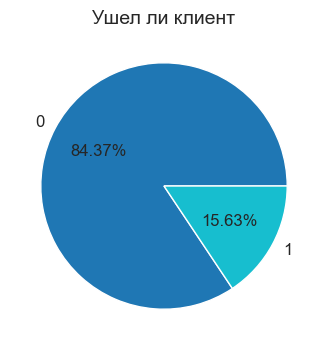

In [29]:
# График по столбцу 'churn'
plt_pie_pivot(teledom, 'churn', 'Ушел ли клиент', figsize=(4,4))

Клиенты, разорвавшие договор, составляют всего **15,63%** от всех данных. Таким образом, наблюдаем дисбаланс классов. Учтем его при моделировании и выборе метрики оценки качества.

### Количественные признаки <a class="anchor" id="количественные"></a>

1) `monthly_charges` - расходы за месяц.

Описательные статистики параметра Ежемесячные расходы


,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


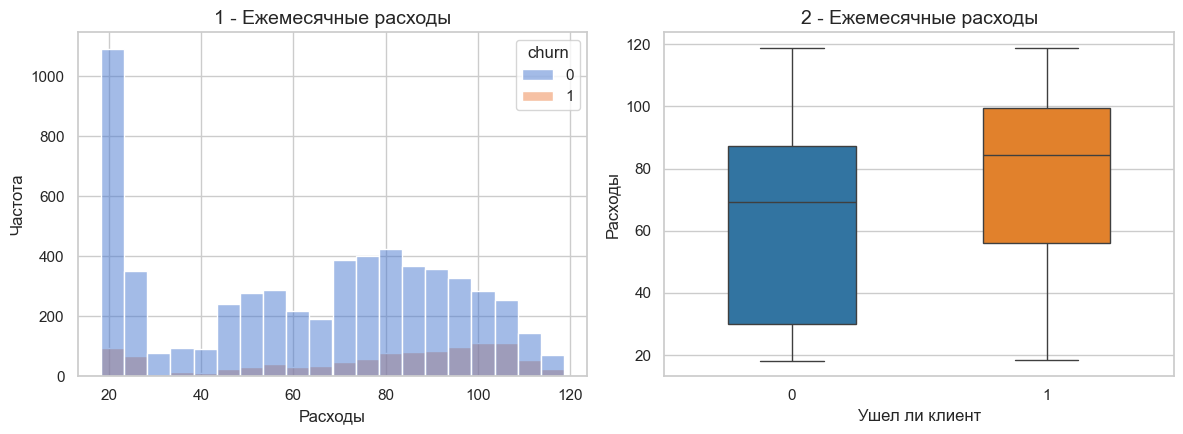

In [30]:
# Графики по столбцу 'monthly_charges'
plt_hist_boxplt(teledom, 'monthly_charges', title='Ежемесячные расходы', 
                hue='churn', label='Расходы', bins=20)

- *Общее распределение*. На гистограмме наблюдаем **бимодальное** распределение. Первый пик - около **20**, где сосредоточено большинство клиентов с низкими расходами. Это может соответствовать базовому тарифу или минимальному ежемесячному платежу. Второй пик — около **70-80**, что может указывать на группу клиентов с более высокими тарифами или доп. услугами.
- *В разрезе целевого признака.* Клиенты, которые ушли, чаще встречаются в диапазоне более высоких расходов (80–120) и медиана их расходов выше (более 70). Клиенты, которые остались, имеют более широкое распределение и медиана их расходов ниже (около 70). Таким образом, можно сделать предположение, что высокие ежемесячные расходы связаны с повышенным оттоком клиентов.

2) `total_charges` - общие расходы абонента.

Описательные статистики параметра Общие расходы


,total_charges
count,7043.000000
mean,2115.312885
std,2112.742814
min,0.000000
25%,436.750000
50%,1343.350000
75%,3236.690000
max,9221.380000


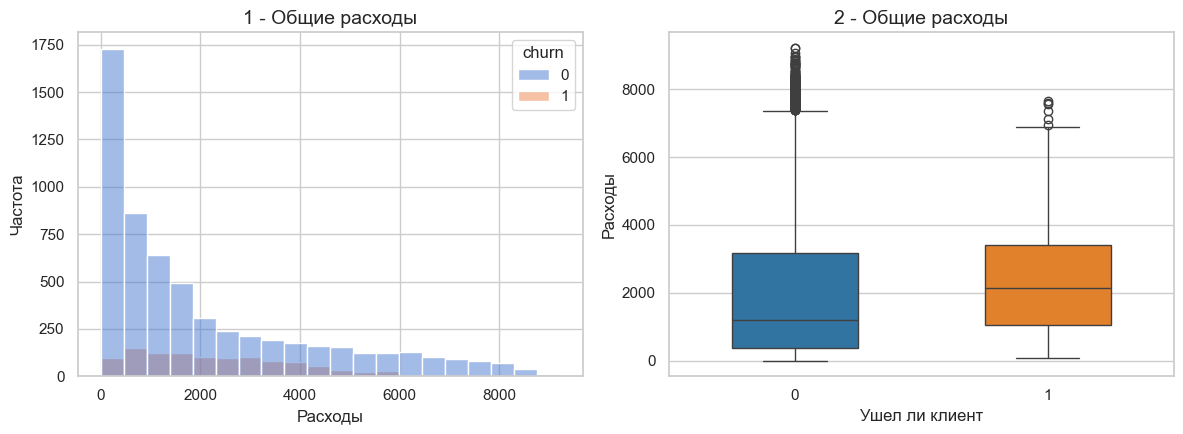

In [31]:
# Графики по столбцу 'total_charges'
plt_hist_boxplt(teledom, 'total_charges', title='Общие расходы', 
                hue='churn', label='Расходы', bins=20)

- *Общее распределение*. На гистограмме наблюдаем явный пик в диапазоне **от 0 до 1000**, т.е. большинство клиентов с низким общим расходом. Это могут быть как новые клиенты, так и довольно длительные договоры, но с минимальными тарифами. Медианное значение составляет 1343.
На диаграммах размаха значения выше 7500 обозначены как выбросы, однако это не ошибочные или аномальные данные.
- *В разрезе целевого признака.* По аналогии с ежемесячными расходами, медиана расходов ушедших клиентов выше (около 2000), чем оставшихся.

3) `contract_duration` - длительность договора в днях.

Описательные статистики параметра Длительность договора


,contract_duration
count,7043.000000
mean,872.401817
std,683.409887
min,-31.000000
25%,245.000000
50%,730.000000
75%,1430.000000
max,2283.000000


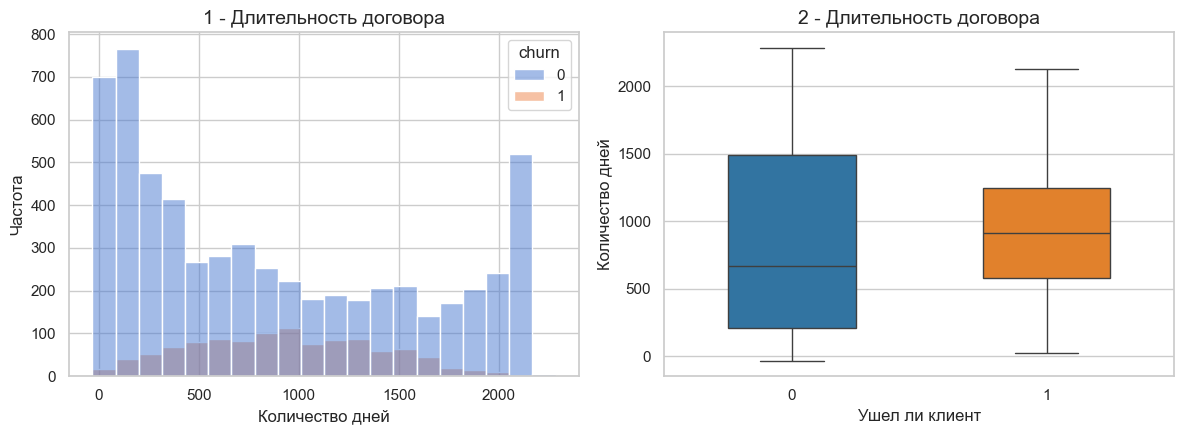

In [32]:
# Графики по столбцу 'contract_duration'
plt_hist_boxplt(teledom, 'contract_duration', title='Длительность договора', 
                hue='churn', label='Количество дней', bins=20)

- *Общее распределение*. На гистограмме видим **бимодальное** распределение. Первый пик - около **50-200**, где сосредоточено большинство клиентов. Это самые новые клиенты, с которыми договор был заключен за последние 6 месяцев. Второй пик — около **2200**, что указывает на группу самых лояльных клиентов (длительность договора свыше 5 лет).
- *В разрезе целевого признака.* В основном длительность договоров ушедших клиентов составляет **500-1200 дней (1,5 - 3,2 года)**. Возможно, компания уделяет больше внимания новым клиентам, игнорируя более "зрелых" клиентов. Отсутствие различного рода поощрений, выгод для лояльных клиентов может послужить причиной их ухода.

### Категориальные признаки <a class="anchor" id="категориальные"></a>

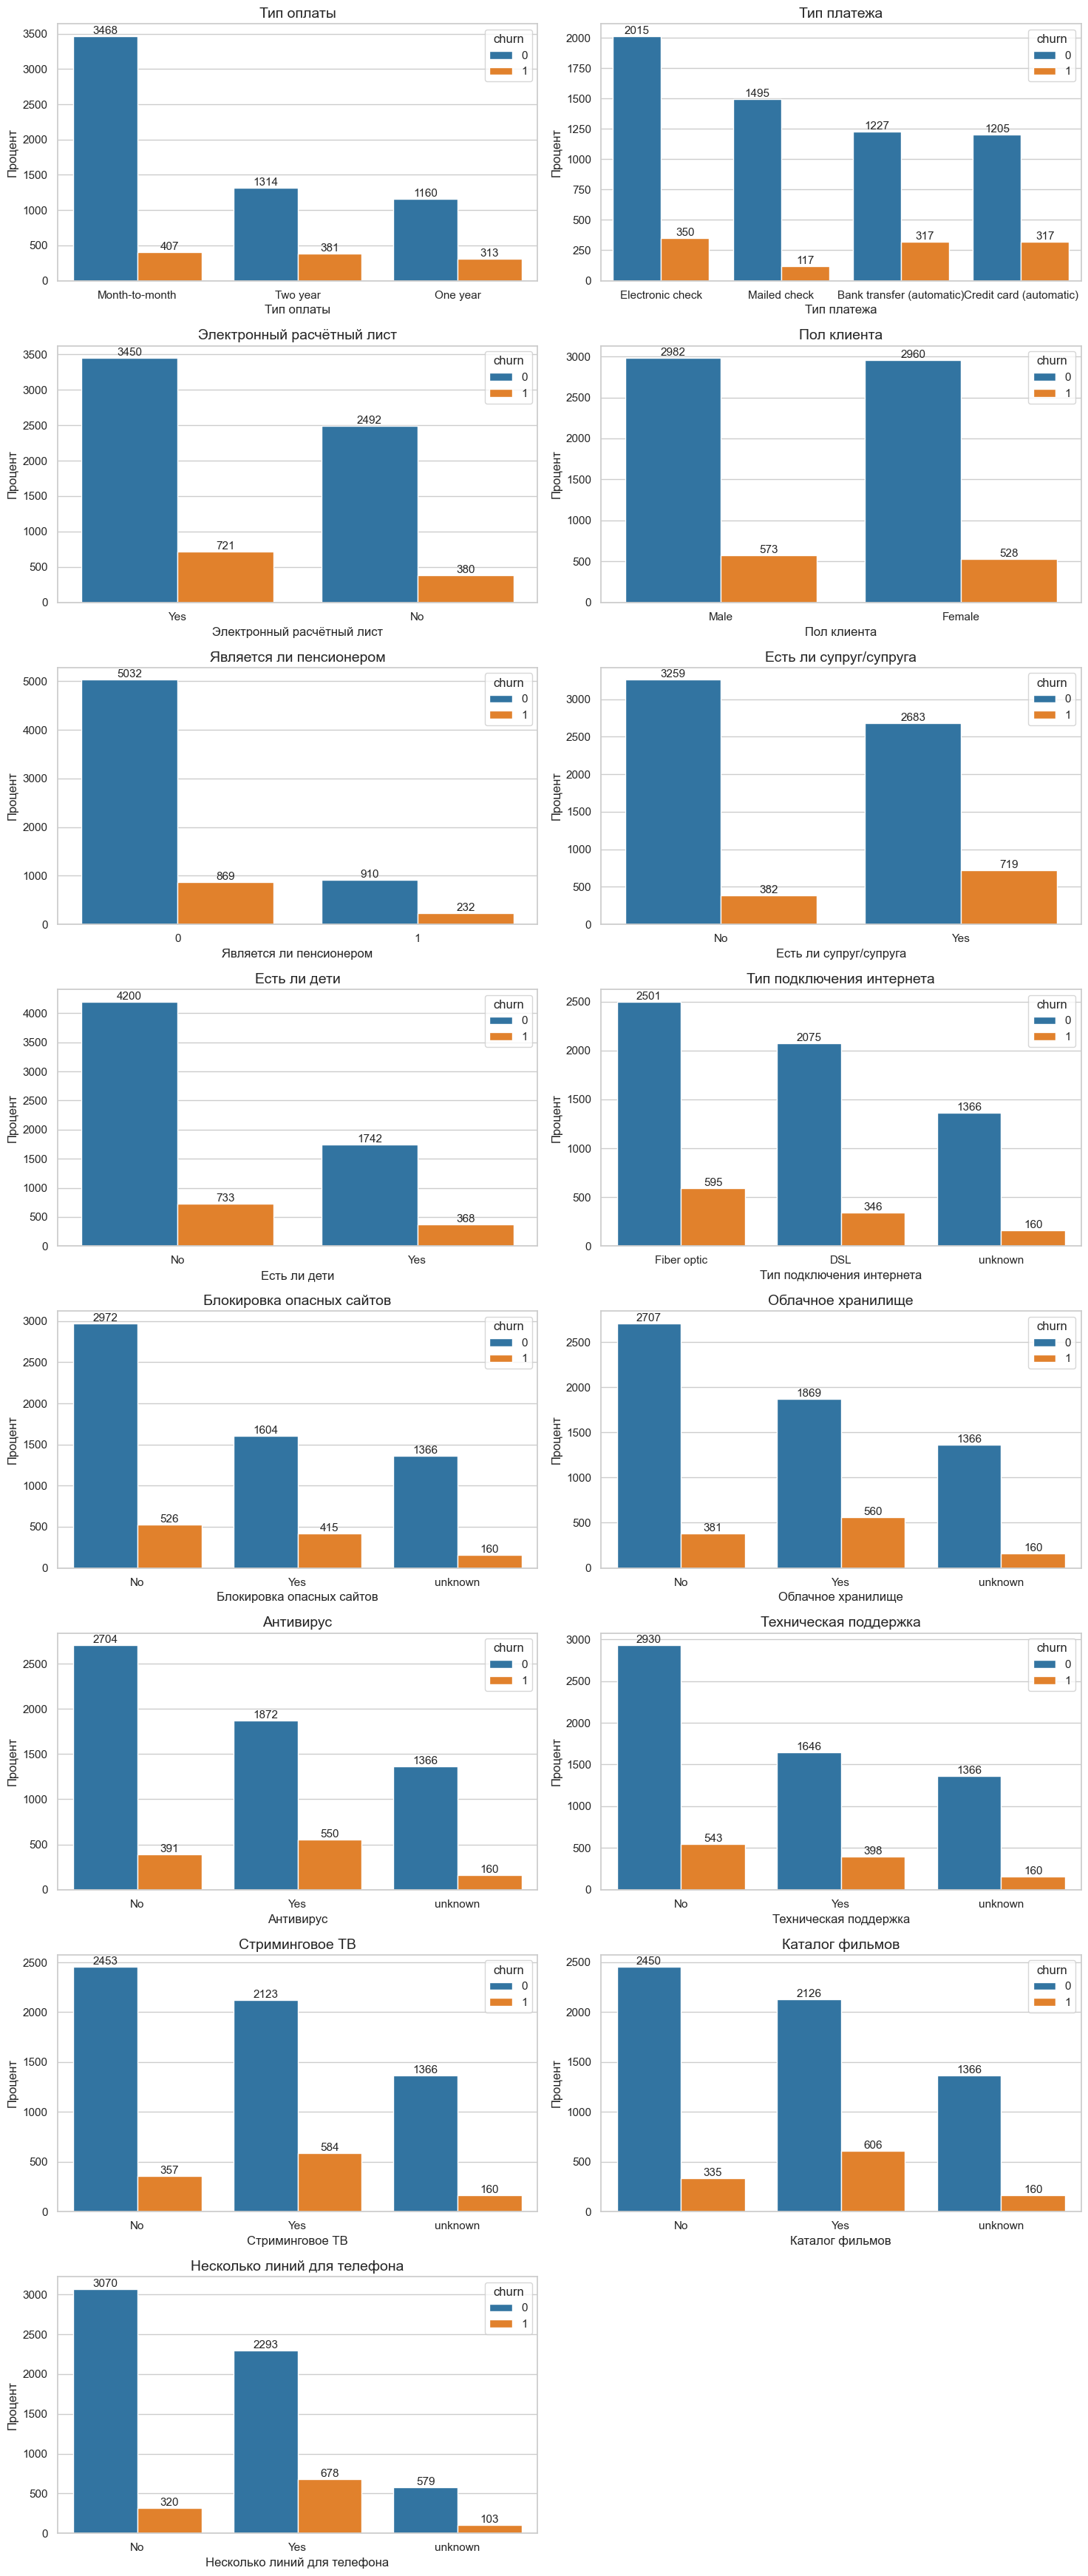

In [33]:
# Список категориальных признаков
columns_barplot = [
    ('Тип оплаты', 'type'), 
    ('Тип платежа', 'payment_method'), 
    ('Электронный расчётный лист', 'paperless_billing'),
    ('Пол клиента', 'gender'),
    ('Является ли пенсионером', 'senior_citizen'),
    ('Есть ли супруг/супруга', 'partner'),
    ('Есть ли дети', 'dependents'),
    ('Тип подключения интернета', 'internet_service'),
    ('Блокировка опасных сайтов', 'online_security'),
    ('Облачное хранилище', 'online_backup'),
    ('Антивирус', 'device_protection'),
    ('Техническая поддержка', 'tech_support'),
    ('Стриминговое ТВ', 'streaming_tv'),
    ('Каталог фильмов', 'streaming_movies'),
    ('Несколько линий для телефона', 'multiple_lines')    
]

# Построение графиков
fig, axes = plt.subplots(8, 2, figsize=(15, 35))
axes = axes.flatten()

for i, (title, col) in enumerate(columns_barplot):
    column_pivot_bar = (
        teledom
        .pivot_table(index=[col, 'churn'], values='customer_id', aggfunc='count')
        .reset_index()
        .sort_values(by='customer_id', ascending=False)
    ) 

    # Столбчатая диаграмма
    sns.barplot(data=column_pivot_bar, x=col, y='customer_id', hue='churn', ax=axes[i], palette='tab10')
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Процент')

    # Добавление меток на столбики
    for container in axes[i].containers:
        axes[i].bar_label(container, fontsize=11)

fig.delaxes(axes[15])
plt.tight_layout()
plt.show()

- **Тип оплаты**. Большинство клиентов оплачивают услуги помесячно. Клиенты, *платившие за услуги раз в год/2 года, чаще других расторгали договор* (в 22% случаев). Причинами этому могут быть большая финансовая нагрузка (высокая разовая оплата воспринимается клиентом тяжелее, чем небольшая, но ежемесячная), а также низкая гибкость и уровень вовлеченности клиента.
- **Тип платежа**. Наибольшее количество клиентов совершают платеж электронным чеком. В разрезе целевого признака выделяются *автоматические платежи* (перевод и кредитной картой): используя их, клиенты чаще расторгают договор (около 20%). Причиной этому может быть низкий уровень контроля клиента.  Автоматизация снижает контакт с компанией, и клиент может реже замечать ценность услуги, а также все изменения в ценообразовании.
- **Электронный расчетный лист**. Большинству клиентов отправляется электронный расчетный лист. На отток клиента данный параметр существенно *не влияет*, взаимосвязь на графике не прослеживается.
- **Пол клиента**. Распределение равномерное. В разрезе целевого признака *различий не наблюдается*.
- **Является ли пенсионером**. Подавляющее большинство клиентов не являются пенсионерами. Клиенты-пенсионеры чуть *чаще других расторгают договор* (отток более 20%). Возможно, данная категория имеет более ограниченные финансовые возможности, и высокая стоимость услуг или отсутствие персонализированного обслуживания может стать причиной расторжения договора.
- **Есть ли супруг/супруга**. Количество клиентов разного семейного положения распределено достаточно равномерно. При этом клиенты *состоящие в браке в 2 раза чаще расторгают договор*, чем неженатые. Это может указывать на сверхвысокие финансовые обязательства или сложности в удовлетворении потребностей более чем одного человека в семье.
- **Есть ли дети**. Большинство клиентов не имеют детей. Их наличие на отток клиента существенно *не влияет.*
- **Тип подключения интернета**. Наибольшей части клиентов интернет подключен через оптоволокно. В разрезе целевого признака существенных *различий в распределении не наблюдается.*
- **Блокировка опасных сайтов**. Большинство клиентов не пользуются данной услугой. Клиенты, *использующие ее, чаще других расторгают договор* (свыше 20%). Возможно, клиентов не устраивает качество услуги либо ее стоимость.
- **Облачное хранилище файлов**. Большинство клиентов не пользуются данной услугой. Клиенты, *подключившие ее, в 2 раза чаще расторгают договор.*
- **Антивирус**. Большинство клиентов не пользуются данной услугой. Здесь также, клиенты, *подключившие ее, в 2 раза чаще расторгают договор.*
- **Выделенная линия технической поддержки**. Большинство клиентов не пользуются данной услугой. Клиенты, *использующие ее, чуть чаще других расторгают договор* (19%). Это может быть показателем низкого качества оказываемой техподдержки или высокой стоимости услуги для клиента.
- **Стриминговое ТВ**. Распределение клиентов, использующих и не использующих услугу, достачно равномерное. При этом клиенты, *подключившие ее, уходят в 23% случаев*, т.е. в 2 раза чаще, чем не подключившие ее. Это может указывать на недостаточную ценность услуги или её несоответствие ожиданиям (низкое качество контента, высокая стоимость и др).
- **Каталог фильмов**. Распределение клиентов, использующих и не использующих услугу, достачно равномерное. Клиенты, *использующие ее, в 2 раза чаще расторгают договор.* Причиной этому может служить недостаточное наполнение каталога, низкое качество или высокая стоимость услуги.
- **Подключение телефона к нескольким линиям**. Большинство клиентов не пользуются данной услугой. Клиенты, подключившие ее, *чаще других расторгают договор* (отток более 22%). Это может указывать на низкий спрос на услугу и её ограниченную полезность для большинства пользователей.

**Выводы**

Рассмотрев основные данные о клиентах, мы проанализировали распределение значений по каждому параметру в целом и в разрезе целевого признака. В результате:

- Ушедшие клиенты составляют 15,63% данных, что указывает на дисбаланс классов.  
- Клиенты с высокими ежемесячными расходами (80–120) чаще разрывают договор.  
- Ушедшие клиенты имеют более высокие общие расходы (медиана ~2000 против ~1343).  
- Договоры длительностью 1,5–3,2 года связаны с повышенным оттоком.  
- Клиенты, использующие годовую/двухгодовую оплату и автоматические платежи чаще расторгают договор (~20-22%).  
- Пенсионеры и клиенты в браке чаще расторгают договор.  
- Использование доплнительных интернет-услуг (стриминговое ТВ, антивирус, каталог фильмов) связано с оттоком клиентов (~22-23%).  
- Подключение телефона к нескольким линиям одновременно повышает вероятность оттока (~22%).
- Пол клиента, наличие у него детей, а также тип подключения интернета не оказывают существенного влияния на вероятность оттока клиента.

## Корреляционный анализ <a class="anchor" id="корреляция"></a>

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции Фи и построим тепловую карту. Используем для расчета все количественные и качественные признаки, кроме `customer_id` (его удалим из расчета).

In [34]:
# Установка 'customer_id' в качестве индекса
teledom.set_index('customer_id', inplace=True)

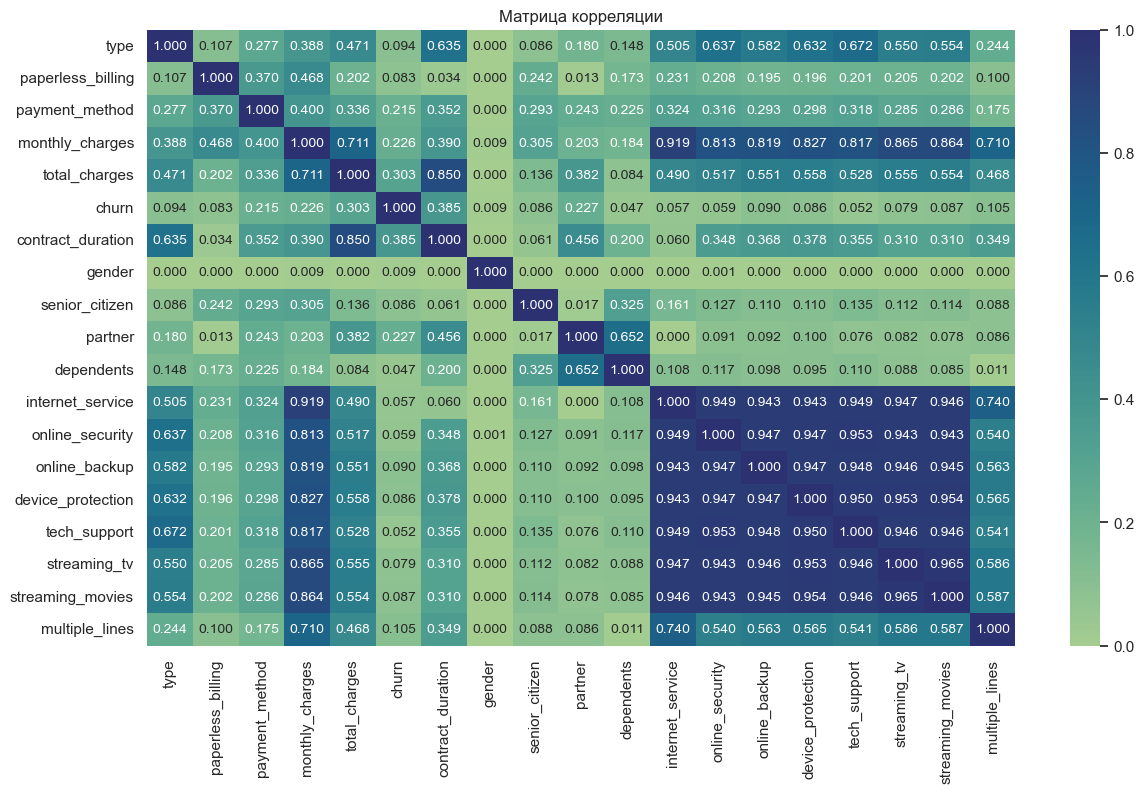

In [35]:
# Расчет корреляции Фи
teledom_phik = (teledom
                .phik_matrix(interval_cols=[
                    'monthly_charges', 
                    'total_charges', 
                    'contract_duration']
                            )
                .round(3)
               )

# Тепловая карта
plt.figure(figsize=(14,8))
sns.heatmap(teledom_phik, annot=True, fmt='.3f', annot_kws={'size': 10}, cmap='crest')
plt.title('Матрица корреляции')
plt.show()

**Выводы:**

Проанализировав матрицу корреляции, выявили следующие взаимосвязи:
- Целевой признак `churn` имеет умеренный уровень корреляции с признаками `contract_duration` (коэфф. 0.385) и  `total_charges` (коэфф. 0.303). С остальными признаками видим слабую корреляцию.
- Наличие мультиколлениарности между признаками с дополнительными интернет-услугами (`online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`) - коэффициенты свыше 0.94. По этой причине, а также потому что данные признаки имеют низкую корреляцию с целевым признаком, *в обучении моделей их использовать не будем*. На их основе созадим новый признак - `internet_extra_service` (количество подключенных доп услуг). Таким образом, мы не потеряем важную информацию по услугам клиентов, но избавимся от мультиколлениарности.
- Признак `gender` показывает практически нулевую корреляцию как с целевым признаком, так и с другими. На этапе EDA мы также выяснили, что пол клиента не взаимосвязан с оттоком клиента. По этим причинам *не будем использовать его* при обучении моделей.

## Подготовка данных к обучению <a class="anchor" id="подготовка"></a>

### Создание признаков <a class="anchor" id="создание_признаков"></a>

Создадим 3 новых признака:
1) **`internet_extra_service`** (количество подключенных доп услуг) - сумма из используемых услуг `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`.

2) **`avg_monthly_charges`** (среднемесячные расходы) - общие расходы (`total_charges`), деленные на длительность контракта в месяцах (`contract_duration` / 30 дней). Данный признак позволит увидеть поведение клиентов в долгосрочной перспективе и возможно некоторые закономерности в расходах.

3) **`monthly_charges_deviation`** (отклонение ежемесячных расходов) - разница между `monthly_charges` (текущие ежемесчные расходы) и `avg_monthly_charges` (ежемесячные расходы за весь период договора). Таким образом, это поможет выявить клиентов с нестабильными платежами; клиентов, менявших тарифы, список услуг и т.д.

In [36]:
# Список доп интернет-услуг для 'internet_extra_service'
internet_extra_col = [
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_tv', 
    'streaming_movies'
]

# Добавление 'internet_extra_service'
teledom['internet_extra_service'] = teledom[internet_extra_col].applymap(lambda x: 1 if x == 'Yes' else 0).sum(axis=1)

# Добавление 'avg_monthly_charges'
teledom['avg_monthly_charges'] = np.where(
    teledom['contract_duration'] == 0,
    teledom['total_charges'],
    teledom['total_charges'] / (teledom['contract_duration'] / 30)
)
teledom['avg_monthly_charges'] = teledom['avg_monthly_charges'].round(2)

# Добавление 'monthly_charges_deviation'
teledom['monthly_charges_deviation'] = (teledom['monthly_charges'] - teledom['avg_monthly_charges']).abs()

# Проверка результата
teledom.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,internet_extra_service,avg_monthly_charges,monthly_charges_deviation
customer_id,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown,1,31.04,1.19
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1005,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,2,61.85,4.90
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,92,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,2,73.75,19.90
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1340,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown,3,43.89,1.59
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,122,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,86.93,16.23


In [37]:
# Удаление списка доп интернет-услуг и пола клиента
teledom.drop(internet_extra_col, axis=1, inplace=True)
teledom.drop(['gender'], axis=1, inplace=True)
teledom.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,contract_duration,senior_citizen,partner,dependents,internet_service,multiple_lines,internet_extra_service,avg_monthly_charges,monthly_charges_deviation
customer_id,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,0,0,Yes,No,DSL,unknown,1,31.04,1.19
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1005,0,No,No,DSL,No,2,61.85,4.90
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,92,0,No,No,DSL,No,2,73.75,19.90
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1340,0,No,No,DSL,unknown,3,43.89,1.59
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,122,0,No,No,Fiber optic,No,0,86.93,16.23


Проанализируем матрицу корреляцию с новыми признаками:

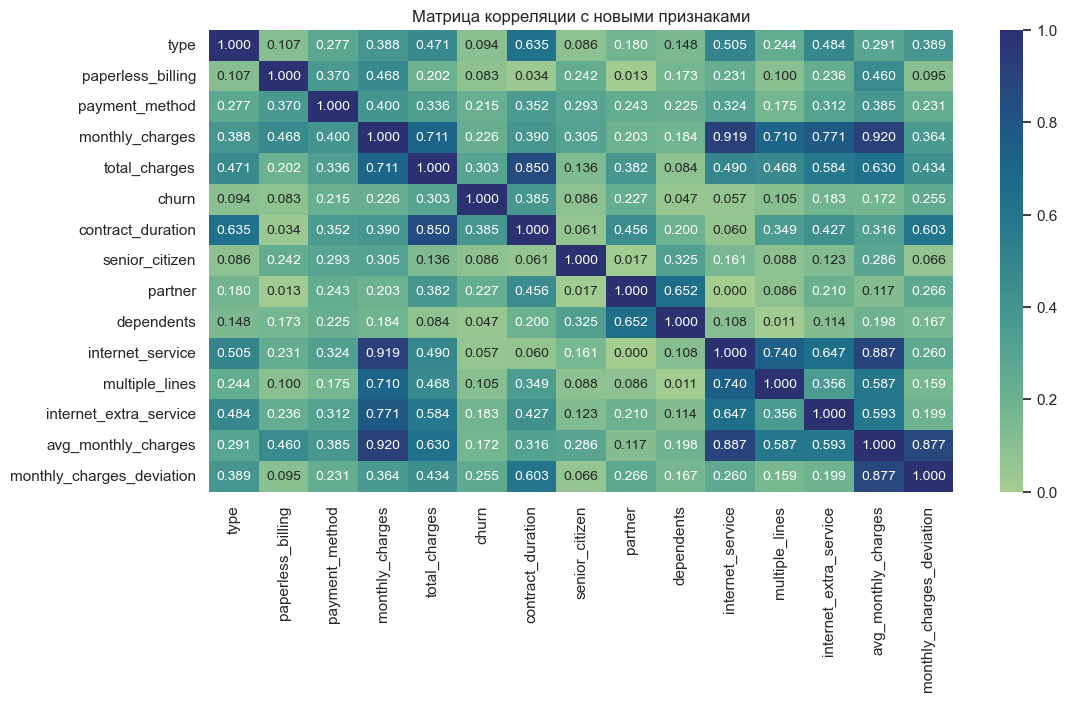

In [38]:
# Расчет корреляции Фи
teledom_phik_new = (teledom
                .phik_matrix(interval_cols=[
                    'monthly_charges',
                    'total_charges', 
                    'contract_duration', 
                    'avg_monthly_charges', 
                    'monthly_charges_deviation']
                            )
                .round(3)
                   )

# Тепловая карта
plt.figure(figsize=(12,6))
sns.heatmap(teledom_phik_new, annot=True, fmt='.3f', annot_kws={"size": 10}, cmap='crest')
plt.title('Матрица корреляции с новыми признаками')
plt.show()

- Посредством удаления списка доп. интернет-услуг мы избавились от мультиколлениарности среди этих признаков. А созданный на их основе `internet_extra_service` показывает более высокий уровень корреляции с целевыми признаком (коэфф. 0.183), чем каждый из отдельных.
- Новые признаки `avg_monthly_charges` и `monthly_charges_deviation` имеют умеренный уровень взаимосвизи с целевым признаком (коэфф. 0.172 и 0.255 соответственно).
- Появились признакми мультиколлениарности между признаками `monthly_charges`-`internet_service`(коэфф.0.919) и `avg_monthly_charges`-`monthly_charges` (0.92). Их взаимосвязь логична. Удалять признаки не станем, т.к. в качестве моделей мы будем использовать те, которые мало или нечувствительны к мультиколлениарности (деревья решений, ансамбли и нелинейные методы).

### Разделение на выборки <a class="anchor" id="разделение"></a>

Разделим данные на тренировочную и тестовую выборки (75/25) с использованием стратификации по целевому признаку для учета дисбаланса классов. А также выделим количественные признаки для масштабирования и категориальные - для кодирования

In [39]:
# Объявление констант
RANDOM_STATE = 91224

# Разделение на целевой и входные признаки
X = teledom.drop(['churn'], axis=1)
y = teledom['churn']

# Разделение данных на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, 
    random_state=RANDOM_STATE,
    stratify=y
)


# Размерность выборок
print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (5282, 14) (5282,)
Размер тестовой выборки: (1761, 14) (1761,)


In [40]:
# Списки с названиями столбцов для кодирования и масштабирования
num_columns = ['monthly_charges', 'total_charges', 'contract_duration', 
               'avg_monthly_charges', 'monthly_charges_deviation', 'internet_extra_service']
cat_columns = ['type', 'payment_method', 'paperless_billing', 
               'partner', 'dependents', 'internet_service', 'multiple_lines']

Создадим пайплайн для подготовки данных.  Для масштабирования числовых признаков будет использован **StandardScaler**. Для кодирования категориальных - **OneHotEncoder** или **OrdinalEncoder** (в зависимости от используемой модели).

In [41]:
def create_pipeline(cat_columns, num_columns, cat_encoding, model):
    '''
    Создает пайплайн на основе предоставленных столбцов и модели.
    
    Args:
        cat_columns (list): категориальные столбцы.
        num_columns (list): числовые столбцы.
        cat_encoding (str): тип кодирования для категориальных столбцов ('ohe', 'ordinal', None).
        model (sklearn model): используемая модель.
    '''
    
    # Определение типа кодирования
    if cat_encoding == 'ohe':
        cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    
    elif cat_encoding == 'ordinal':
        cat_transformer = Pipeline([
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ])
    
    else:
        cat_transformer = 'passthrough'

    # Список трансформеров
    transformers = [
        ('cat', cat_transformer, cat_columns),
        ('num', StandardScaler(), num_columns)
    ]

    # Общий ColumnTransformer
    data_preprocessor = ColumnTransformer(transformers)

    # Итоговый пайплайн
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])

    return pipe_final

Для подбора наилучших гиперпараметров для каждой модели будем использовать **GridSearchCV**. Для оценки качества моделей будет применяться метрика **ROC-AUC**, т.к. она не чувствительна к дисбалансу классов.

In [42]:
def best_model_grid(pipeline, param_distr, X_train, y_train, verbose=1):
    '''
    Проводит подбор гиперпараметров модели с помощью GridSearchCV и вычисляет ключевые метрики.

    Args:
        pipeline (Pipeline): Итоговый пайлайн для подготовки данных.
        param_distr (dict): Диапазон для поиска гиперпараметров GridSearchCV.
        X_train(pd.DataFrame): Входные признаки тренировочной выборки.
        y_train(pd.Series): Целевой признак тренировочной выборки.
        
    Вывод:
        - Лучшие параметры модели.
        - ROC-AUC на кросс-валидации.
    '''

    # Настройка GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_distr,
        cv=5,
        scoring='roc_auc',
        verbose=verbose
    )
    
   # Подбор параметров
    grid_search.fit(X_train, y_train)

    # Модель с лучшими параметрами
    best_model = grid_search.best_estimator_

    # Расчет ROC-AUC
    roc_auc_cv = grid_search.best_score_

    # Вывод результатов
    print(f'Лучшие параметры: {grid_search.best_params_}')
    print(f'Метрика ROC-AUC на кросс-валидации: {roc_auc_cv}')
 
    return best_model, roc_auc_cv

**Выводы:**
- Создали 3 новых признака для дальнейшего моделирования - `avg_monthly_charges`, `monthly_charges_deviation`, `internet_extra_service`.
- Удалили из данных малоинформативные признаки (пол клиента и признаки с доп. интернет-услугами).
- Разделили данные на выборки.
- Для подготовки данных к последующему обучению модели создали пайплайн. Для заполнения пропущенных значений будет использоваться SimpleImputer, для кодирования категориальных признаков - OneHotEncoder и OrdinalEncoder; для масштабирования количественных признаков - StandardScaler.

## Обучение моделей <a class="anchor" id="обучение"></a>

Для поиска лучшей модели протестируем 5 вариантов:
- **LogisticRegression**
- **KNeighborsClassifier**
- **RandomForestClassifier**
- **LGBMClassifier**
- **CatBoostClassifier**

Т.к. в целевом признаке имеется существенный дисбаланс классов, при обучении моделей будем использовать **балансировку классов**. Это поможет моделям уделять больше внимания редкому классу (ушедшие клиенты), что для задачи оттока клиентов крайне важно. Рассчитаем веса на основе количества классов:

In [43]:
# Расчет весов классов
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.array([0, 1]), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.5926840215439856, 1: 3.1973365617433416}


### LogisticRegression <a class="anchor" id="logreg"></a>

In [44]:
# Создание пайплайна
pipeline_log_reg = create_pipeline(
    cat_columns, 
    num_columns, 
    'ohe',
    model=LogisticRegression(
        random_state=RANDOM_STATE, 
        class_weight=class_weights_dict)
)

# Гиперпараметры LogisticRegression
params_log_reg = {
    'model__C': np.arange(50, 100, 0.5)
}

# Подбор гиперпараметров и обучение модели
log_reg_model, log_reg_roc_auc = best_model_grid(
    pipeline_log_reg, 
    params_log_reg, 
    X_train, 
    y_train,
    verbose=1
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'model__C': 99.5}
Метрика ROC-AUC на кросс-валидации: 0.8713162373724558


### KNeighborsClassifier <a class="anchor" id="knn"></a>

In [45]:
# Создание пайплайна 
pipeline_knn = create_pipeline(
    cat_columns, 
    num_columns, 
    'ohe', 
    KNeighborsClassifier()
)

# Гиперпараметры для KNeighborsClassifier
params_knn = {
    'model__n_neighbors': np.arange(5, 80, 5),
    'model__metric': ['cityblock', 'minkowski', 'euclidean'],
    'model__weights': ['uniform', 'distance']
}

# Подбор гиперпараметров и обучение модели
knn_model, knn_roc_auc = best_model_grid(
    pipeline_knn, 
    params_knn, 
    X_train, 
    y_train,
    verbose=1
)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Лучшие параметры: {'model__metric': 'cityblock', 'model__n_neighbors': 70, 'model__weights': 'distance'}
Метрика ROC-AUC на кросс-валидации: 0.8524479042650327


### RandomForestClassifier <a class="anchor" id="rf"></a>

In [46]:
# Создание пайплайна 
pipeline_rf = create_pipeline(
    cat_columns, 
    num_columns, 
    'ordinal', 
    RandomForestClassifier(
        random_state=RANDOM_STATE, 
        class_weight=class_weights_dict)
)

# Гиперпараметры для RandomForestClassifier
params_rf = {
    'model__n_estimators': np.arange(100, 500, 50),
    'model__min_samples_split': range(2, 5)
}

# Подбор гиперпараметров и обучение модели
rf_model, rf_roc_auc = best_model_grid(
    pipeline_rf, 
    params_rf, 
    X_train, 
    y_train,
    verbose=1
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры: {'model__min_samples_split': 2, 'model__n_estimators': 300}
Метрика ROC-AUC на кросс-валидации: 0.9278884910755973


### LGBMClassifier <a class="anchor" id="lgbm"></a>

In [47]:
# Создание пайплайна для LGBMRegressor
pipeline_lgbr = create_pipeline(
    cat_columns, 
    num_columns, 
    'ordinal',
    LGBMClassifier(
        random_state=RANDOM_STATE,
        class_weight=class_weights_dict,
        verbose=-1)
)

# Гиперпараметры для LGBMRegressor
params_lgbr = {
    'model__n_estimators': range(100, 400, 20),  
    'model__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Подбор гиперпараметров и обучение модели
lgbr_model, lgbr_roc_auc = best_model_grid(
    pipeline_lgbr, 
    params_lgbr, 
    X_train, 
    y_train,
    verbose=1
)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Лучшие параметры: {'model__learning_rate': 0.3, 'model__n_estimators': 220}
Метрика ROC-AUC на кросс-валидации: 0.9533929942837267


### CatBoostClassifier <a class="anchor" id="catboost"></a>

In [48]:
# Создание пайплайна
pipeline_catboost = create_pipeline(
    cat_columns, 
    num_columns, 
    'ordinal',
    CatBoostClassifier(
        loss_function='Logloss', 
        random_state=RANDOM_STATE, 
        class_weights=class_weights_dict,
        verbose=0)
)

# Гиперпараметры для CatBoostClassifier
params_catboost = {
    'model__iterations': range(500, 800, 20), 
    'model__learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Подбор гиперпараметров и обучение модели
catboost_model, catboost_roc_auc = best_model_grid(
    pipeline_catboost, 
    params_catboost, 
    X_train, 
    y_train,
    verbose=1
)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Лучшие параметры: {'model__iterations': 740, 'model__learning_rate': 0.1}
Метрика ROC-AUC на кросс-валидации: 0.954022311141021


**Выводы:**

В результате было обучено 5 моделей. Для каждой модели с помощью GridSearchCV были подобраны гиперпараметры, с которыми модель показывает наилучшую метрику ROC-AUC. Гиперпараметры моделей:
- **LogisticRegression** - 'model__C': 99.5.
- **KNeighborsClassifier** - 'model__metric': 'cityblock', 'model__n_neighbors': 70, 'model__weights': 'distance'.
- **RandomForestClassifier** - 'model__min_samples_split': 2, 'model__n_estimators': 300.
- **LGBMClassifier** - 'model__learning_rate': 0.3, 'model__n_estimators': 220.
- **CatBoostClassifier** - 'model__iterations': 740, 'model__learning_rate': 0.1.

## Анализ результатов <a class="anchor" id="анализ"></a>

### Выбор лучшей модели <a class="anchor" id="выбор"></a>

Добавим результаты всех моделей в датафрейм и сравним их:

In [49]:
# Создание датафрейма с результатами моделей
models_results = pd.DataFrame({
    'model': [
        'LogisticRegression', 
        'KNeighborsClassifier', 
        'RandomForestClassifier', 
        'LGBMClassifier', 
        'CatBoostClassifier'
    ],
    'ROC_AUC_cv' : [
        log_reg_roc_auc, 
        knn_roc_auc, 
        rf_roc_auc, 
        lgbr_roc_auc,
        catboost_roc_auc
    ]
}).sort_values(by='ROC_AUC_cv', ascending=False)

display(models_results)

,model,ROC_AUC_cv
4,CatBoostClassifier,0.954022
3,LGBMClassifier,0.953393
2,RandomForestClassifier,0.927888
0,LogisticRegression,0.871316
1,KNeighborsClassifier,0.852448


В результате наилучшее качество предсказаний показала модель **CatBoostClassifier** с метрикой ROC-AUC на кросс-валидации **0.954022**.

Проверим качество выбранной модели на тестовой выборке. А также построим матрицу ошибок.

ROC-AUC на тестовой выборке: 0.95651
Accuracy на тестовой выборке: 0.92334
Recall на тестовой выборке: 0.77091
Precision на тестовой выборке: 0.74648


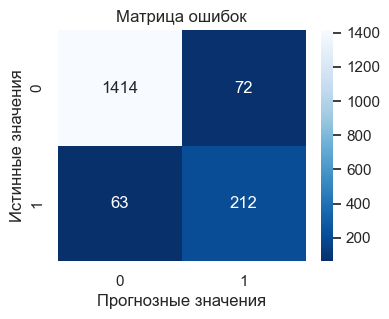

In [50]:
# Предсказание на тестовой выборке
y_prob = catboost_model.predict_proba(X_test)[:, 1]
y_pred = catboost_model.predict(X_test)

# Расчёт ключевых метрик
roc_auc_test = roc_auc_score(y_test, y_prob)
acc_test = accuracy_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)

# Вывод результатов
print(f'ROC-AUC на тестовой выборке: {roc_auc_test:.5f}',
      f'Accuracy на тестовой выборке: {acc_test:.5f}', 
      f'Recall на тестовой выборке: {recall_test:.5f}', 
      f'Precision на тестовой выборке: {precision_test:.5f}', 
      sep='\n'
)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Прогнозные значения');

- **ROC-AUC = 0.9561**. Модель достаточно хорошо справляется с предсказанием классов (ушедших и не ушедших клиентов).
- **Accuracy = 0.92334**. Общее качество предсказаний высокое — модель верно предсказала около 92% всех объектов. Однако эта метрика может быть завышена из-за дисбаланса классов.
- **Recall = 0.77091**. Показывает, что модель нашла **77%** объектов из класса '1' (ушедшие клиенты).
- **Precision = 0.74648** Из всех объектов, которые модель отнесла к классу '1' (ушедшие клиенты), почти **75%** действительно принадлежат этому классу. 

Модель в целом работает **хорошо**, что подтверждается высоким ROC-AUC и Accuracy. Значения Recall и Precision близки, что говорит о сбалансированной работе модели: она хорошо находит положительные классы, при этом не перегружая результат ложно положительными результатами.

Возможна дальнейшая оптимизации порога классификации. Текущие значения Recall и Precision зависят от выбранного порога вероятности классификации. Порог можно изменить в зависимости от расчета финансовых потерь. Например, если стоимость пропущенного положительного случая (ушедшего клиента) выше, чем стоимость ложноположительного случая, то можно сместить порог в сторону увеличения Recall. Для принятия такого решения необходим расчет потерь в денежном выражении, однако данной информацией мы не разполагаем.

### Проверка адекватности модели <a class="anchor" id="адекватность"></a>

После выбора лучшей модели, оценим её адекватность. Для этого сравним результаты лучшей модели с базовой моделью — DummyClassifier, которая прогнозирует наиболее часто встречающуюся метку в данных. Это позволит понять, насколько предсказания сложной модели лучше базового решения.

In [51]:
# Обучение модели DummyClassifier
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# Получение предсказаний
y_dummy_prob = dummy_model.predict_proba(X_test)[:, 1]
roc_auc_dummy = roc_auc_score(y_test, y_dummy_prob)

# Вывод результатов
print(f'ROC-AUC DummyClassifier: {roc_auc_dummy:.5f}')
print(f'Разница между CatBoostClassifier и DummyClassifier: {roc_auc_test - roc_auc_dummy:.5f}')

ROC-AUC DummyClassifier: 0.50000
Разница между CatBoostClassifier и DummyClassifier: 0.45651


Проверка адекватности показала, что ROC-AUC для базовой модели, предсказывающей среднее, составил 0.5. Разница между лучшей моделью (CatBoostClassifier) и DummyClassifier составила 0.45651, что свидетельствует о значительном улучшении качества предсказаний. Это подтверждает, что использование более сложной модели оправдано, и она значительно лучше базового предсказания.

### Важность признаков <a class="anchor" id="важность"></a>

,Признаки,Важность
11,monthly_charges_deviation,29.716378
9,contract_duration,22.489339
7,monthly_charges,11.152953
10,avg_monthly_charges,9.412569
8,total_charges,7.685923
0,type,4.258502
12,internet_extra_service,3.686951
1,payment_method,2.833419
3,partner,2.222936
5,internet_service,2.028677


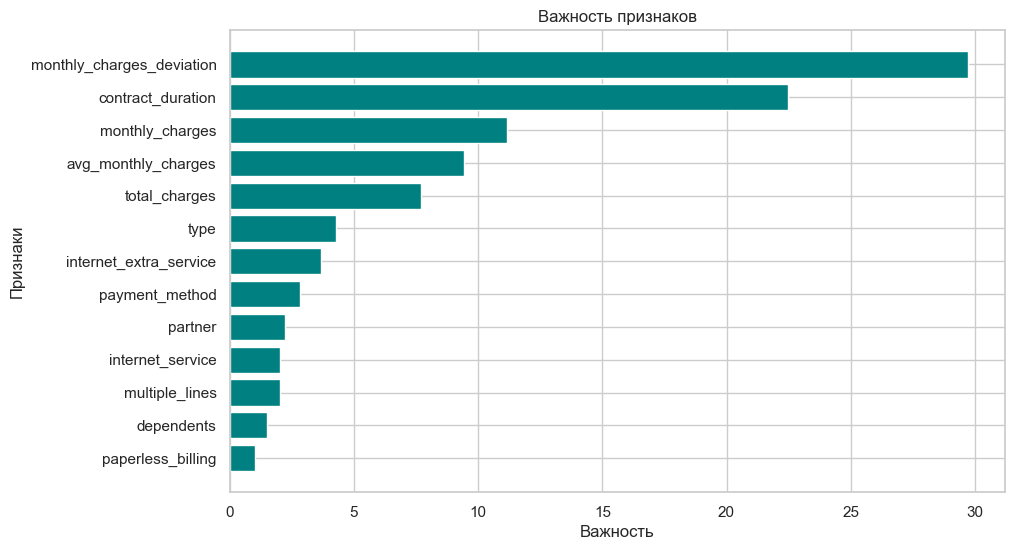

In [52]:
# Получение важности признаков
catboost = catboost_model.named_steps['model']
feature_importances = catboost.feature_importances_

# Названия признаков
feature_names = cat_columns + num_columns

# Создание датафрейма с признаками и их важностью
feature_importance_df = pd.DataFrame({
    'Признаки': feature_names,
    'Важность': feature_importances
}).sort_values(by='Важность', ascending=False)

# Вывод важности признаков
display(feature_importance_df)

# График важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Признаки'], feature_importance_df['Важность'], color='teal')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.gca().invert_yaxis()
plt.show()

- Признаками, которые сильнее всего влияют на целевой являются `monthly_charges_deviation` (самое большое влияние на предсказания модели), `contract_duration` и `monthly_charges`.
- 
Наименьшее влияние на целевой признак оказывают`paperless_billing`, `dependents`.

Попробуем **удалить наименее важные для модели признаки** и проверим, как это скажется на метрике качества:.

### Доработка лучшей модели <a class="anchor" id="доработка"></a>

Удалим из входных признаков `paperless_billing`, `dependents` и обучим CatBoostClassifier:

In [53]:
# Выделение входных признаков
X_less_features = teledom.drop(['churn', 
                                'paperless_billing', 
                                'dependents'], axis=1)

# Разделение данных на выборки
X_train_less_features, X_test_less_features, y_train, y_test = train_test_split(
    X_less_features,
    y,
    test_size=0.25, 
    random_state=RANDOM_STATE,
    stratify=y
)

# Списки с названиями столбцов для кодирования
cat_columns_less_features = ['type', 'payment_method', 'partner', 
                             'internet_service', 'multiple_lines']

# Создание пайплайна
pipeline_catboost_lf = create_pipeline(
    cat_columns_less_features, 
    num_columns, 
    'ordinal',
    CatBoostClassifier(
        loss_function='Logloss', 
        random_state=RANDOM_STATE, 
        class_weights=class_weights_dict,
        verbose=0))

# Подбор гиперпараметров и обучение модели
catboost_model_lf, catboost_roc_auc_lf = best_model_grid(
    pipeline_catboost_lf, 
    params_catboost, 
    X_train_less_features, 
    y_train,
    verbose=1
)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Лучшие параметры: {'model__iterations': 660, 'model__learning_rate': 0.1}
Метрика ROC-AUC на кросс-валидации: 0.9542717837776697


,Признаки,ROC_AUC_cv,ROC_AUC_test,Accuracy_test,Recall_test,Precision_test
1,Без paperless_billing и dependents,0.954272,0.961008,0.925610,0.774545,0.755319
0,Все признаки,0.954022,0.956510,0.923339,0.770909,0.746479


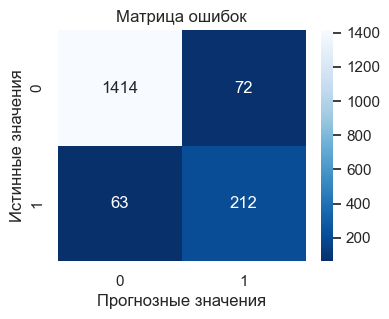

In [54]:
# Предсказание на тестовой выборке
y_prob_lf = catboost_model_lf.predict_proba(X_test_less_features)[:, 1]
y_pred_lf = catboost_model_lf.predict(X_test_less_features)

# Расчёт ключевых метрик
roc_auc_test_lf = roc_auc_score(y_test, y_prob_lf)
acc_test_lf = accuracy_score(y_test, y_pred_lf)
recall_test_lf = recall_score(y_test, y_pred_lf)
precision_test_lf = precision_score(y_test, y_pred_lf)

# Создание датафрейма со сравнением результатов
metric_comparison = pd.DataFrame({
    'Признаки': [
        'Все признаки',
        'Без paperless_billing и dependents'
    ],
    'ROC_AUC_cv': [
        catboost_roc_auc,
        catboost_roc_auc_lf
    ],
    'ROC_AUC_test': [
        roc_auc_test,
        roc_auc_test_lf
    ],
    'Accuracy_test': [
        acc_test,
        acc_test_lf
    ],
    'Recall_test': [
        recall_test,
        recall_test_lf
    ],
    'Precision_test': [
        precision_test,
        precision_test_lf
    ]
}).sort_values(by='ROC_AUC_cv', ascending=False)

display(metric_comparison)

# Матрица ошибок
cm_lf = confusion_matrix(y_test, y_pred_lf)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Прогнозные значения');

Удаление наименее важных признаков положительно повлияло на модель, все **ключевые метрики выросли**. Таким образом, признаки `paperless_billing` и `dependent` не вносили значимого вклада в предсказания модели и могли содержать избыточную информацию или шум. В итоговом варианте будет использовать модель без этих признаков.

**Выводы**
- В результате тестирования наилучшее качество предсказаний показала модель **CatBoostClassifier** с метрикой ROC-AUC на кросс-валидации **0.954022**.
- Модель была проверена на адекватность путем сравнения с DummyClassifier. Разница между ними составила 0.45651, что свидетельствует о значительном улучшении качества предсказаний.
- Проанализировали важность признаков для модели. Сильнее всего влияют на целевой признак `monthly_charges_deviation`, `contract_duration` и `monthly_charges`. Наименьшее влияние на целевой признак оказывают `paperless_billing`, `dependents`.
- Протестировали модель CatBoostClassifier без наименее важных признаков, в результате чего все ключевые метрики выросла.

Итоговый вариант лучше модели CatBoostClassifier показал следующие метрики:
1) **ROC-AUC на кросс-валидации    - 0.954272**
2) **ROC-AUC на тестовой выборке   - 0.961008**
3) **Accuracy на тестовой выборке  - 0.925610**
4) **Recall на тестовой выборке    - 0.774545**
5) **Precision на тестовой выборке - 0.746479**

## Общий вывод <a class="anchor" id="вывод"></a>

В ходе проведенного исследования были выполнены следующие этапы и получены следующие основные результаты.

1) **Предобработка данных**
- Был создан целевой признак `churn` (отток клиентов), а также входной признак `contract_duration`.
- Было удалено 2 неинформативных признака. 
- Обработаны неявные пропуски (0,15% от всех данных), заполнены на 0.
- Были проверены явные и неявные дубликаты, их не обнаружили.
- Все данные были приведены к корректным типам.
***
2) **Объединение данных**
- Все данные были объеденены в один датафрейм - teledom, включающий в себя 7043 уникальных клиента.
- Пропущенные значения, появившиеся после объединения данных, были заполнены на значение 'unknown'.
***
3) **Исследовательский анализ данных**
- Ушедшие клиенты составляют 15,63% данных, что указывает на дисбаланс классов.
- Выявили, какие клиенты чаще других расторгают договор: с высокими ежемесячными и общими расходами; клиенты, использующие годовую/двухгодовую оплату и автоматические платежи; пенсионеры и клиенты в браке; использующие доплнительные интернет-услуги и подключение телефона к нескольким линиям одновременно.
- Пол клиента, наличие у него детей, а также тип подключения интернета не оказывают существенного влияния на вероятность оттока клиента.
***
4) **Корелляционный анализ данных**
- Целевой признак `churn` имеет умеренный уровень корреляции с признаками `contract_duration` (коэфф. 0.385) и `total_charges` (коэфф. 0.303). С остальными признаками видим слабую корреляцию.
- Наличие мультиколлениарности между признаками с дополнительными интернет-услугами (`online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`) - коэффициенты свыше 0.94.
***
5) **Подготовка данных к обучению**
- Создали 3 новых признака - `avg_monthly_charges`, `monthly_charges_deviation`, `internet_extra_service`.
- Удалили из данных малоинформативные признаки (пол клиента и признаки с доп. интернет-услугами).
***
6) **Обучение моделей**

Для масштабирования числовых признаков был использован StandardScaler, для кодирования категориальных признаков - OneHotEncoder и OrdinalEncoder зависимостиоти от модели). Для подбора наилучших гиперпараметров для каждой модели был использован GridSearchCV. При обучении моделей использовали балансировку классов из-за наличия дисбаланса классов в целевом признаке.

В результате было обучено 5 моделей **LogisticRegression, KNeighborsClassifier, RandomForestClassifier, LGBMClassifier, CatBoostClassifier**. Для каждой модели рассчитана ROC-AUC.
***
7) **Анализ результатов**
- Наилучшее качество предсказаний с самым высоким значением ROC-AUC (0.954022) показала **CatBoostClassifier**.
- В результате анализа важности признаков выявили признаки, которые сильнее всего влияют на целевой - `monthly_charges_deviation`, `contract_duration` и `monthly_charges`. Наименьшее влияние на целевой признак оказывают `paperless_billing`, `dependents`.
- После удаления наименее важных признаков все ключевые метрики выросли, поэтому в итогом варианте модели они не используются.

Итоговый вариант лучшей модели **CatBoostClassifier** показал следующие метрики:
- **ROC-AUC на кросс-валидации - 0.954272**
- **ROC-AUC на тестовой выборке - 0.961008**
- **Accuracy на тестовой выборке - 0.925610**
- **Recall на тестовой выборке - 0.774545**
- **Precision на тестовой выборке - 0.746479**
***
8) **Итоги исследования**
- В ходе исследования была разработана модель для предсказания оттока клиентов оператора связи, что позволит компании заранее выявлять пользователей, планирующих разорвать договор, и предложить им персонализированные условия для удержания.
- Наилучшие результаты показала модель CatBoostClassifier с высоким значением ROC-AUC на тестовой выборке 0.961008. Эта модель соответствует критериям заказчика и показывает достаточно высокий уровень точности.

*Рекомендации для бизнеса*:
- Больше внимания для клиентов с высокими расходами. Клиенты с высокими ежемесячными платежами (80–120) чаще расторгают договор. Рекомендуем разработать спецпредложения и скидки для этой категории.
- Удержание клиентов со "средней" длительностью договора — пользователи с длительностью контракта 1,5–3,2 года часто разрывают договор. Важно внедрить программы лояльности и поощрения для этой группы.
- Доработка/пересмотр дополнительных интернет-услуг (стриминговое ТВ, антивирус, облачное хранилище и др.), т.к. они связаны с повышенным оттоком. Необходимо улучшить их качество, пересмотреть ценообразование.
- Повышение вовлеченности клиентов, особенно теми, кто использует автоматические платежи, чтобы поддерживать их осведомленность о ценности услуг, важных изменениях.